In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

sys.path.append('../src')
from recommenders.recommender_system import RecommenderSystem
from recommenders.item_based_rs import ItemBasedRecommenderSystem
from recommenders.user_based_rs import UserBasedRecommenderSystem
from utils.similarity_measure import cosine_similarity, adjusted_cosine_similarity
from utils.data_splitter import get_data

# Load data, model

In [5]:
train_df, test_df = get_data(data_path='../data/ratings.csv', train_over_test_ratio=4, random_state=42)

In [3]:
item_based_rs_cosine = RecommenderSystem.load_model(path='../saved_models/item_based_rs_cosine.pkl')

In [8]:
user_based_rs_cosine = RecommenderSystem.load_model(path='../saved_models/user_based_rs_cosine.pkl')

# Experiments

## 1. Effect of Similarity Algorithm

In [ ]:
MAEs_for_each_ratio = []
for x in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    train_df, test_df = get_data(data_path='/content/drive/MyDrive/recommender_system/RecommenderSystem/data/ratings.csv', train_over_test_ratio = x, random_state=42)
    item_based_rs = ItemBasedRecommenderSystem(train_df)
    item_based_rs.fit()
    MAE = item_based_rs.evaluate(test_df)
    print(f"x = {x}: MAE = {MAE}")
    MAEs_for_each_ratio.append(x)

MAEs_for_each_ratio


## 2.  Sensitivity of Training/Test Ratio

## 3.  Experiments with neighborhood size

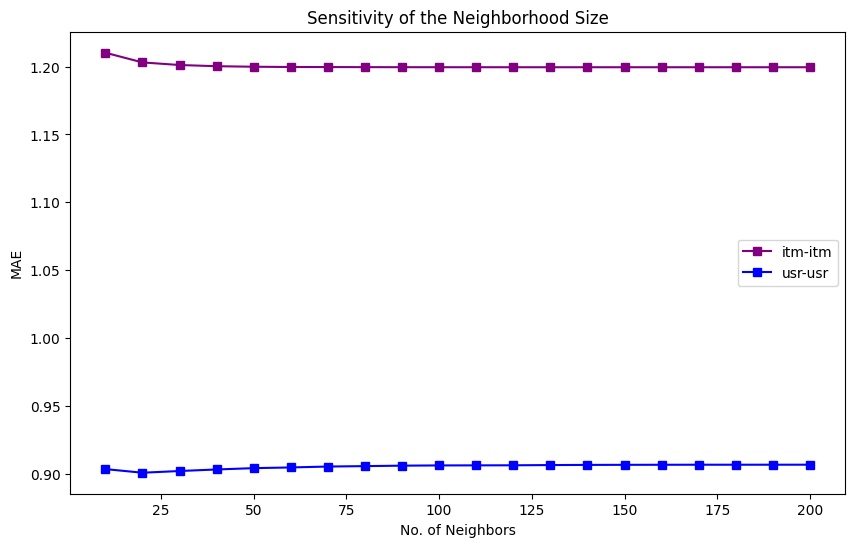

In [10]:
item_based_cosine_MAEs = []
user_based_cosine_MAEs = []
for k_neighbors in range(10, 210, 10):
    item_based_cosine_MAEs.append(item_based_rs_cosine.evaluate(test_df, k_neighbors=k_neighbors, metric=mean_absolute_error))
    user_based_cosine_MAEs.append(user_based_rs_cosine.evaluate(test_df, k_neighbors=k_neighbors, metric=mean_absolute_error))
    
fig_ex_3 = plt.figure(figsize=(10, 6))
plt.plot([k_neighbors for k_neighbors in range(10, 210, 10)], item_based_cosine_MAEs, 's-', color='purple', label='itm-itm')
plt.plot([k_neighbors for k_neighbors in range(10, 210, 10)], user_based_cosine_MAEs, 's-', color='blue', label='usr-usr')
plt.title('Sensitivity of the Neighborhood Size')
plt.xlabel('No. of Neighbors')
plt.ylabel('MAE')
plt.legend()



In [ ]:
fig_ex_3.savefig('../figures/ex_3.png')